# Tutorial 1: Simulated Data (Spatial Patterns of Varying Complexity)

- **Purpose**: Evaluate the INR module's ability to simultaneously capture diverse spatial patterns while maintaining spatial smoothness;
- **Dataset**: Simulated dataset 1: Spatial Patterns of Varying Complexity(https://doi.org/10.5281/zenodo.14854747).

## Loading package

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import scanpy as sc
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
import anndata as ad
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'
import sys
sys.path.append(r'D:/study/learning\spatial_transcriptome/papers\spatial_multi_omics-main')
from Model.utils import mclust_R
from Model.model import DCCAE
from Model.preprocess import fix_seed
fix_seed(2024)

## Loading data

In [ ]:
# read data
replicate = 1
file_fold_1 = f'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Spatial_Scenario_{replicate}/simulation{replicate}_RNA'
file_fold_2 = f'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Spatial_Scenario_{replicate}/simulation{replicate}_Protein'

adata_omics_1 = sc.read_h5ad(file_fold_1 + '.h5ad')
adata_omics_2 = sc.read_h5ad(file_fold_2 + '.h5ad')

adata_omics_1.X = adata_omics_1.uns['INR']
adata_omics_2.X = adata_omics_2.uns['INR']

batch = 2
adata_RNA = adata_omics_1[adata_omics_1.obs['batch'] == batch]
adata_ADT = adata_omics_2[adata_omics_2.obs['batch'] == batch]

sc.tl.pca(adata_RNA, use_highly_variable=False)
sc.tl.pca(adata_ADT, use_highly_variable=False)

## Training the model

In [ ]:
n_DCCA = 10

features1 = adata_RNA.obsm['X_pca'].shape[1]  # Feature sizes
features2 = adata_ADT.obsm['X_pca'].shape[1]
layers1 = [256, 256, n_DCCA]  # nodes in each hidden layer and the output size
layers2 = [256, 256, n_DCCA]
X = adata_RNA.obsm['X_pca'].copy()
Y = adata_ADT.obsm['X_pca'].copy()

use_rep = ['DCCA_X', "DCCA_Y", "DCCA"]

epochs = 300
dcca = DCCAE(input_size1=features1, input_size2=features2, n_components=n_DCCA, layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=epochs, learning_rate=0.001)
dcca.fit([X, Y])
Xs_transformed = dcca.transform([X, Y])
adata_RNA.obsm["DCCA_X"] =  Xs_transformed[0]
adata_ADT.obsm["DCCA_Y"] =  Xs_transformed[1]
adata_RNA.obsm["DCCA"] = np.concatenate((adata_RNA.obsm["DCCA_X"], adata_ADT.obsm["DCCA_Y"]),axis=1)

use_rep = ['DCCA_X','DCCA_Y', 'DCCA']
n = 4
mclust_R(adata_RNA, used_obsm=use_rep[0], num_cluster=n)
obs_df = adata_RNA.obs.dropna()
ARI_1 = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
print(f'n={n}, DCCA_X, ARI = {ARI_1}')
    
mclust_R(adata_ADT, used_obsm=use_rep[1], num_cluster=n)
obs_df = adata_ADT.obs.dropna()
ARI_2 = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
print(f'n={n}, DCCA_Y, ARI = {ARI_2}')

mclust_R(adata_RNA, used_obsm=use_rep[2], num_cluster=n)
obs_df = adata_RNA.obs.dropna()
ARI_3 = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
print(f'n={n}, DCCA, ARI = {ARI_3}')

Training Progress: 100%|██████████| 300/300 [00:08<00:00, 33.38it/s]

model training finished!
fitting ...
  |                                                                            

  |======================================================================| 100%
n=4, DCCA_X, ARI = 1.0
fitting ...
  |======================================================================| 100%
n=4, DCCA_Y, ARI = 0.9666599600683922
fitting ...
  |======================================================================| 100%
n=4, DCCA, ARI = 1.0


## Storing the results

In [ ]:
adata_1 = ad.AnnData(obs=adata_RNA.obs[['clusters_mclust', 'batch']], obsm={'SpaKnit': adata_RNA.obsm['DCCA']})
adata_2 = ad.AnnData(obs=adata_RNA.obs[['clusters_mclust', 'batch']], obsm={'SpaKnit': adata_RNA.obsm['DCCA']})
adata_3 = ad.AnnData(obs=adata_RNA.obs[['clusters_mclust', 'batch']], obsm={'SpaKnit': adata_RNA.obsm['DCCA']})
adata_results = adata_1.concatenate(adata_2, adata_3, batch_key='batch')

obs_df = adata_results.obs
obs_df = obs_df.rename(columns={'clusters_mclust': 'SpaKnit'})
adata_results.obs = obs_df

results = sc.read_h5ad(f'./Results/Spatial_Scenario_{replicate}.h5ad')
results.obs['SpaKnit'] = adata_results.obs['SpaKnit'].values
results.obsm['SpaKnit'] = adata_results.obsm['SpaKnit']
results.write_h5ad(f'./Results/Spatial_Scenario_{replicate}.h5ad')

AnnData object with n_obs × n_vars = 1200 × 3031
    obs: 'Ground Truth', 'batch', 'SpaGCN', 'SpatialGlue', 'STAGATE', 'MultiMAP', 'MultiVI', 'Modality1', 'Modality2', 'SpaKnit'
    obsm: 'Modality1', 'Modality2', 'MultiMAP', 'MultiVI', 'STAGATE', 'SpatialGlue', 'spatial', 'SpaKnit'

## Visualizing results

In [ ]:
replicate = 1
adata_analysis = sc.read_h5ad(f'./Results/Spatial_Scenario_{replicate}.h5ad')

batch = '0'   ## 0, 1, 2
adata_analysis = adata_analysis[adata_analysis.obs['batch']==batch]

In [ ]:
def reorder_categories(adata, method, new_order):
    """
    Reorder the categories of a given method in the AnnData object's.obs.
    
    Parameters:
    adata: AnnData object
    method: str, the name of the method to reorder
    new_order: list, the new order of categories
    """
    if not pd.api.types.is_categorical_dtype(adata.obs[method]):
        adata.obs[method] = pd.Categorical(adata.obs[method])
    adata.obs[method] = adata.obs[method].cat.reorder_categories(new_order)

new_orders = {
    'SpaKnit': [1, 3, 4, 2]
}

for method, new_order in new_orders.items():
    reorder_categories(adata_analysis, method, new_order)

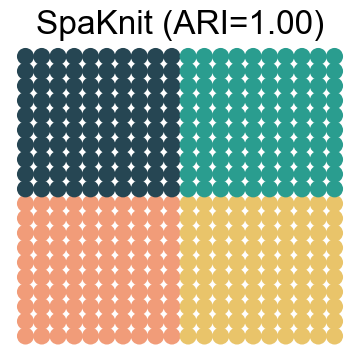

In [29]:
method = 'SpaKnit'

plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = ['Arial']

colors_domain = [
    '#f19c79', '#e9c46a', '#2a9d8f', '#264653'
]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# Calculate Adjusted Rand Index (ARI)
ari_value = adjusted_rand_score(adata_analysis.obs['Ground Truth'], adata_analysis.obs[method])
sc.pl.embedding(adata_analysis, basis='spatial', color=[method], title=None, s=600, colorbar_loc=None, show=False, ax=ax, palette=colors_domain, legend_loc=None)
# Set the title, including the ARI value
ax.set_title(f"{method} (ARI={ari_value:.2f})")
ax.set_xlabel('')
ax.set_ylabel('')

# Hide the borders of the axes
for spine in ax.spines.values():
    spine.set_visible(False)

# Adjust subplot parameters to reduce blank areas around the plot
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.tight_layout()

# Display the plot
plt.show()